# UCF-Crime Anomaly Detection - Colab Setup

Setup notebook for running MIL Ranking Loss re-implementation on Google Colab.

## 1. Check GPU

In [7]:
!nvidia-smi

# Verify PyTorch can use GPU
import torch
print(f"\nPyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Sun Nov 30 11:31:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              8W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Mount Google Drive

**Prerequisites:**
1. Upload features.zip and annotations.zip to Google Drive
2. Google Drive structure:
```
MyDrive/
└── Colab Notebooks/
    └── data_distribution/
        ├── features.zip
        └── annotations.zip
```

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Clone Repository

In [ ]:
!git clone https://github.com/KwonPodo/MILRankingLoss_Sultani2018_ReImplementation.git
%cd MILRankingLoss_Sultani2018_ReImplementation

## 4. Install Packages

**Note:** Using `requirements-colab.txt` to avoid package conflicts

In [9]:
# Install minimal packages for Colab (avoid conflicts)
!pip install -r requirements-colab.txt -q

# Check installed package versions
import torch
import numpy as np
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")

PyTorch: 2.9.0+cu126
NumPy: 2.0.2


## 5. Extract Data

Extract features from Google Drive.

In [10]:
import os

# Verify working directory
%cd /content/MILRankingLoss_Sultani2018_ReImplementation
!pwd

# Create data directory
!mkdir -p data

# Google Drive path
DRIVE_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data_distribution'

# Extract features
!cp "{DRIVE_DATA_PATH}/features.zip" data/
!unzip -q data/features.zip -d data/
!rm data/features.zip

print("Features extracted")
!ls -lh data/

/content/MILRankingLoss_Sultani2018_ReImplementation
/content/MILRankingLoss_Sultani2018_ReImplementation
replace data/features/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Features extracted
total 4.0K
drwxr-xr-x 17 root root 4.0K Nov 30 11:31 features


## 6. Extract Annotations

Extract annotation files from Google Drive.

In [11]:
# Extract annotations from Google Drive
!cp "{DRIVE_DATA_PATH}/annotations.zip" data/
!unzip -q data/annotations.zip -d data/
!rm data/annotations.zip

print("Annotations extracted")
!ls -lh data/annotations/

Annotations extracted
total 100K
-rwxr-xr-x 1 root root 16K Jan  3  2023 Temporal_Anomaly_Annotation_for_Testing_Videos.txt
-rwxr-xr-x 1 root root 13K Oct 31 17:28 test_set.txt
-rwxr-xr-x 1 root root 66K Oct 31 17:28 train_set.txt


## 7. Verify Dataset

In [12]:
# Verify working directory
%cd /content/MILRankingLoss_Sultani2018_ReImplementation

# Check feature categories
!ls data/features/

# Check sample counts
!echo "Train samples:"
!wc -l data/annotations/train_set.txt
!echo "Test samples:"
!wc -l data/annotations/test_set.txt

/content/MILRankingLoss_Sultani2018_ReImplementation
Abuse	Assault    Fighting	  Shooting     Testing_Normal_Videos_Anomaly
Arrest	Burglary   RoadAccidents  Shoplifting  Training_Normal_Videos_Anomaly
Arson	Explosion  Robbery	  Stealing     Vandalism
Train samples:
1610 data/annotations/train_set.txt
Test samples:
290 data/annotations/test_set.txt


## 8. Test Dataset Loading

In [13]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation
!PYTHONPATH=/content/MILRankingLoss_Sultani2018_ReImplementation:$PYTHONPATH python scripts/test_dataset.py

/content/MILRankingLoss_Sultani2018_ReImplementation
Total samples in dataset: 1610
Positive samples: 810
Negative samples: 800

First batch:

Positive bags: torch.Size([30, 32, 4096])

Negative bags: torch.Size([30, 32, 4096])
Batch 0: pos=30, neg=30
Batch 1: pos=30, neg=30
Batch 2: pos=30, neg=30
Batch 3: pos=30, neg=30


## 9. Test Model

In [14]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation
!PYTHONPATH=/content/MILRankingLoss_Sultani2018_ReImplementation:$PYTHONPATH python scripts/test_model.py

/content/MILRankingLoss_Sultani2018_ReImplementation
Model architecture:
AnomalyDetector(
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 2,114,113

Positive scores shape: torch.Size([30, 32])
Negative scores shape: torch.Size([30, 32])
Score range: [0.4717, 0.5796]

Total loss: 1.0406
  Ranking loss: 0.9999
  Smoothness loss: 0.6181
  Sparsity loss: 507.8174

Training mode loss: 1.0406


## 10. Start Training

### Option 1: Train without WandB

In [15]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation
!PYTHONPATH=/content/MILRankingLoss_Sultani2018_ReImplementation:$PYTHONPATH python train.py --config configs/default.yaml --no-wandb

/content/MILRankingLoss_Sultani2018_ReImplementation
Loaded config from configs/default.yaml
Using device: cuda
Train dataset: 1610 videos
Positive samples: 810
Negative samples: 800
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Total batches per epoch: 26
Model parameters: 2,114,113
Optimizer: adam

Starting training for 100 epochs...
Epoch 1:   0% 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smal

## 11. Evaluate

Evaluate trained model.

In [16]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation
!PYTHONPATH=/content/MILRankingLoss_Sultani2018_ReImplementation:$PYTHONPATH python evaluate.py \
    --config configs/default.yaml \
    --checkpoint checkpoints/best_model.pth \
    --temporal-annotation data/annotations/Temporal_Anomaly_Annotation_for_Testing_Videos.txt

/content/MILRankingLoss_Sultani2018_ReImplementation
Loaded config from configs/default.yaml
Using device: cuda
Loaded model from checkpoints/best_model.pth
Epoch: 100, Loss: 0.4930
Test dataset: 290 videos
Loaded temporal annotations for 290 videos

Evaluating model...
Evaluating: 100% 290/290 [00:12<00:00, 22.49it/s]

Total segments evaluated: 9280
Anomaly segments: 1685 (18.2%)
Normal segments: 7595 (81.8%)

Calculating ROC curve...
ROC curve saved to results/roc_curve.png
PR curve saved to results/pr_curve.png

AUC: 0.7007
Results saved to results/evaluation_results.json

Optimal threshold: 0.0092
  TPR: 0.6404
  FPR: 0.3276

Summary saved to results/evaluation_summary.txt


## 12. View Results

/content/MILRankingLoss_Sultani2018_ReImplementation


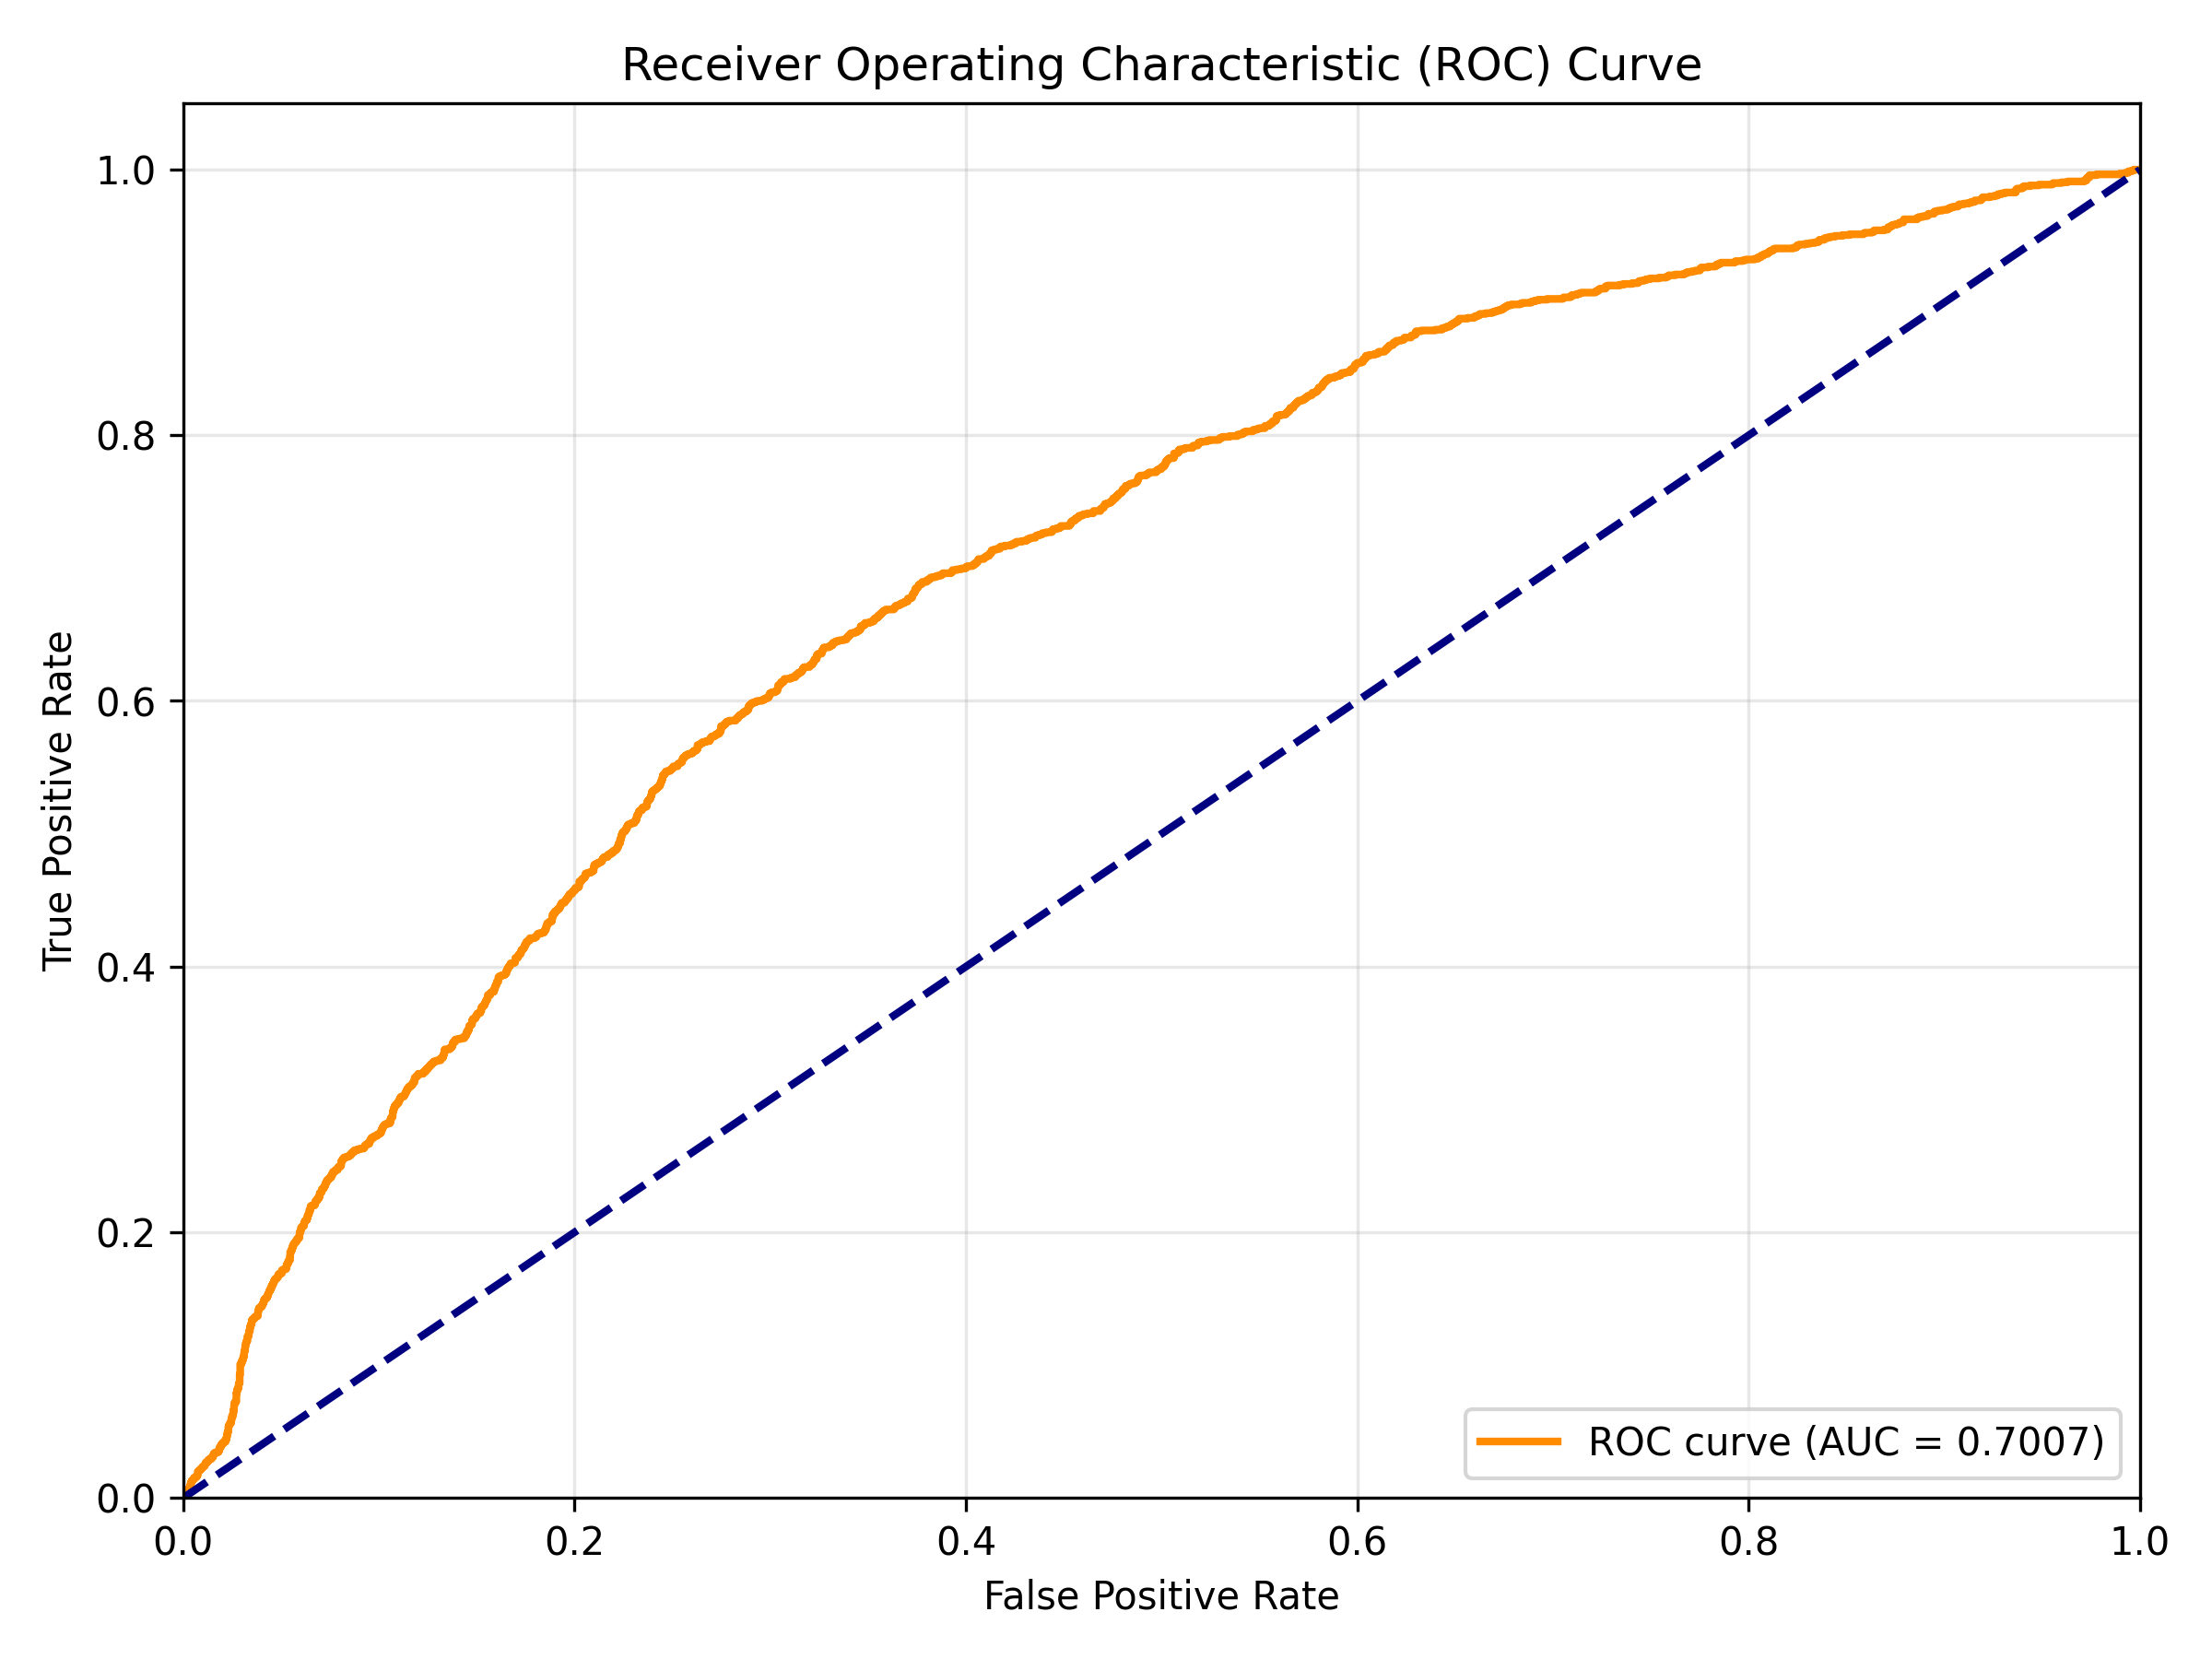

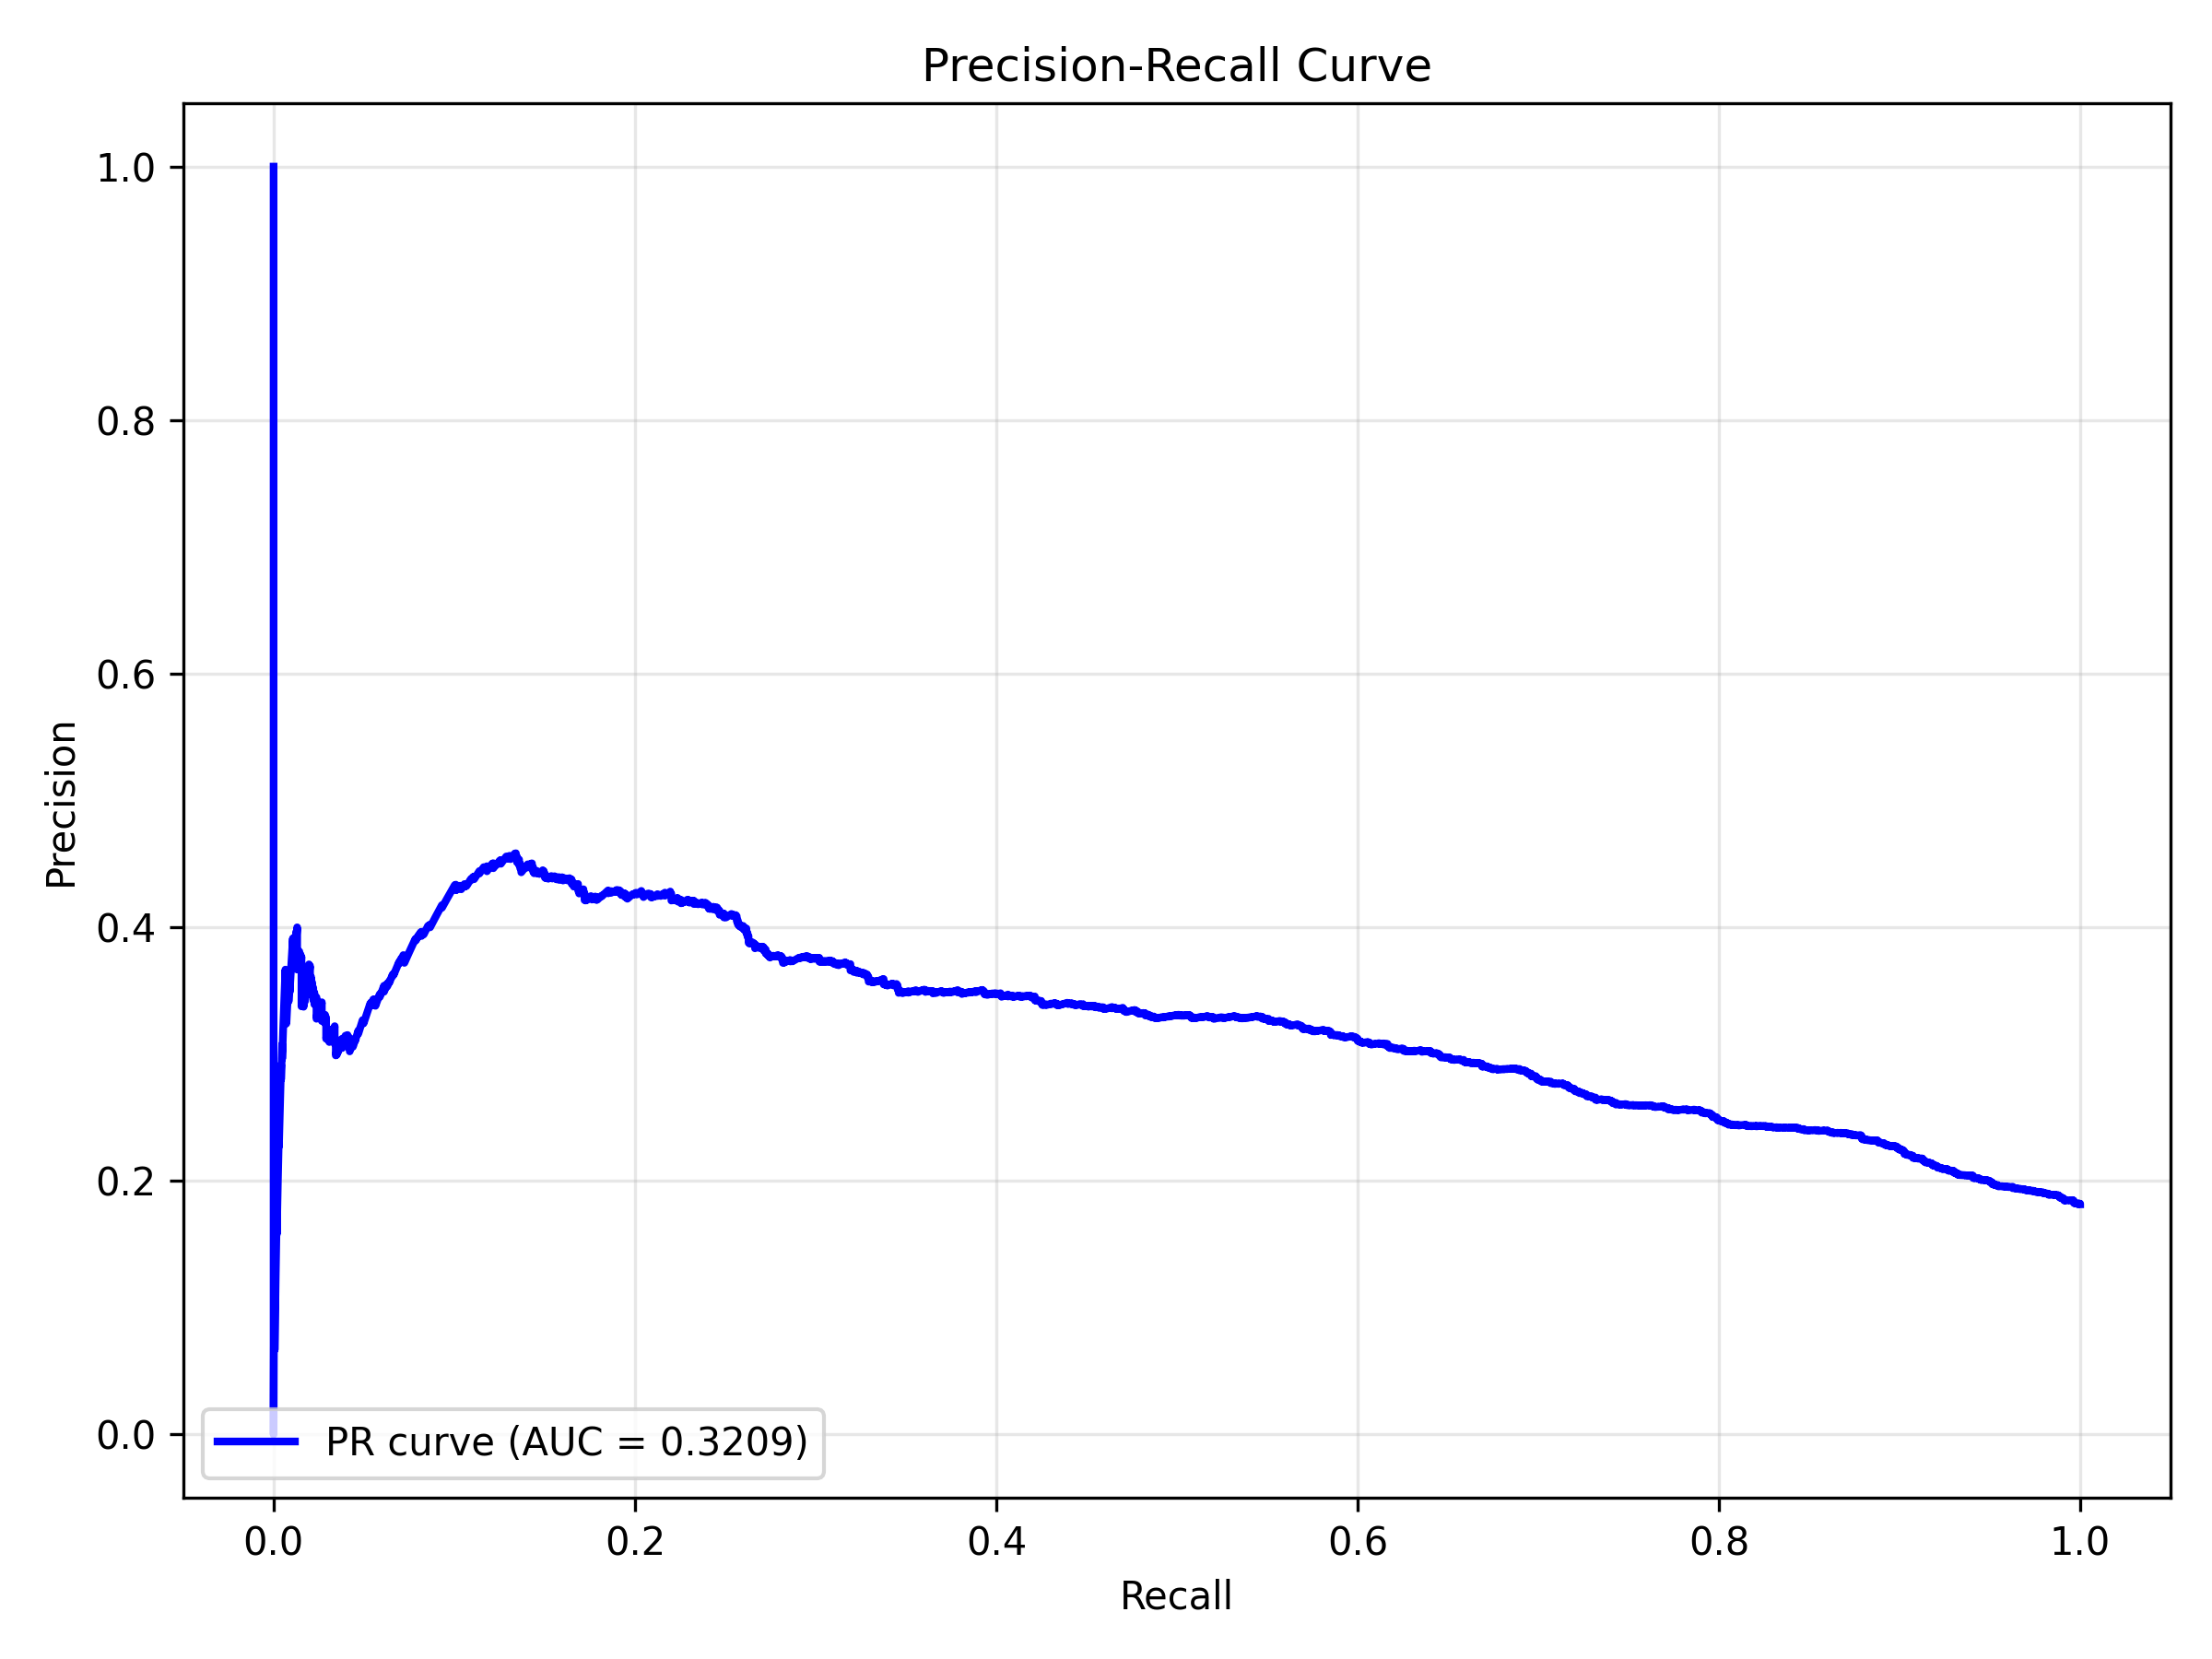

Evaluation Summary
Model: checkpoints/best_model.pth
Test videos: 290
Total segments: 9280
Anomaly segments: 1685 (18.2%)

Results:
  AUC: 0.7007
  Optimal threshold: 0.0092
  TPR at optimal: 0.6404
  FPR at optimal: 0.3276


In [17]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation

# Display ROC curve
from IPython.display import Image, display
import os

if os.path.exists('results/roc_curve.png'):
    display(Image('results/roc_curve.png'))


if os.path.exists('results/pr_curve.png'):
    display(Image('results/pr_curve.png'))

# Print evaluation results
if os.path.exists('results/evaluation_summary.txt'):
    !cat results/evaluation_summary.txt

## 13. (Optional) Save Results to Google Drive

In [ ]:
%cd /content/MILRankingLoss_Sultani2018_ReImplementation

# Backup checkpoints and results to Drive
DRIVE_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data_distribution'
!mkdir -p "{DRIVE_DATA_PATH}/results"
!cp -r checkpoints "{DRIVE_DATA_PATH}/"
!cp -r results "{DRIVE_DATA_PATH}/"

print("Results saved to Google Drive")

/content/MILRankingLoss_Sultani2018_ReImplementation


My new model:
LeakyReLU Activation Function:

Before: The original model used the ReLU activation function.

After: I replaced ReLU with LeakyReLU. This modification allows a small, non-zero gradient when the input is negative (by setting a small slope, negative_slope=0.01). This is beneficial because, with ReLU, some neurons can "die" during training (i.e., they stop updating because they always output 0 for negative inputs). LeakyReLU mitigates this problem by allowing small negative values to propagate.

Why: LeakyReLU helps the model learn more efficiently, especially in deep networks where dead neurons can be a problem, improving the overall performance and training stability.

Dropout Regularization:

Before: The original model didn't have dropout regularization, which can lead to overfitting, especially with complex models and limited data.

After: I added Dropout with a rate of 0.5 (50% chance of dropping a neuron during training).

Why: Dropout helps prevent overfitting by randomly setting a fraction of input units to zero during each forward pass. This encourages the model to not rely too heavily on any single neuron, thus improving generalization to unseen data.

Batch Normalization:

Before: The original model didn't use Batch Normalization.

After: I added Batch Normalization after each fully connected layer (FC1 and FC2). This normalizes the output of each layer to have zero mean and unit variance, which stabilizes and speeds up training.

Why: Batch Normalization helps the model learn faster by reducing internal covariate shift, which can lead to better performance, especially in deeper networks.

Network Architecture Changes:

Before: The original model had a simpler architecture with just two fully connected layers: 4096 -> 512 and 512 -> 1.

After: I added a third fully connected layer with 512 -> 64 neurons. This gives the model an additional layer of abstraction, which could help it learn more complex patterns.

Why: Increasing the depth of the network allows the model to learn more complex representations of the data. With the additional layer, the network can model finer-grained relationships between input features, which should improve its ability to detect anomalies.

Sigmoid Activation:

Before: The original model used a Sigmoid function at the output layer, which is still maintained in the new model.

Why: The Sigmoid activation is useful for binary classification tasks (0 or 1), where we want the output to represent the probability of an anomaly. Since this is an anomaly detection task, the Sigmoid activation ensures that the model outputs a value between 0 and 1, representing the likelihood of each segment being an anomaly.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ImprovedAnomalyDetector(nn.Module):
    """
    Improved 3-layer fully connected network for anomaly detection with dropout, batch normalization, and LeakyReLU.
    Architecture:
    - FC1: 4096 -> 512 (LeakyReLU + BatchNorm + Dropout 0.5)
    - FC2: 512 -> 64 (LeakyReLU + BatchNorm + Dropout 0.5)
    - FC3: 64 -> 1 (Sigmoid)
    """

    def __init__(self, input_dim=4096, dropout=0.5):
        super(ImprovedAnomalyDetector, self).__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Args:
            x: (batch_size, num_segments, feature_dim)
                e.g., (30, 32, 4096)

        Returns:
            scores: (batch_size, num_segments)
                    Anomaly score for each segment (0~1)
        """
        batch_size, num_segments, feature_dim = x.shape

        # Reshape to process all segments at once
        x = x.view(-1, feature_dim)  # (batch_size * num_segments, 4096)

        # FC layers with BatchNorm, LeakyReLU, and Dropout
        x = self.fc1(x)           # (batch_size * num_segments, 512)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)           # (batch_size * num_segments, 64)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc3(x)           # (batch_size * num_segments, 1)
        x = self.sigmoid(x)

        # Reshape back
        scores = x.view(batch_size, num_segments)  # (batch_size, 32)

        return scores


1. Regularization of Smoothness and Sparsity with Alpha:

Before: In the original MILRankingLoss class, the smoothness and sparsity constraints were used directly in the loss function. The weights for these constraints, λ1 (smoothness) and λ2 (sparsity), were defined, but there was no control over how much these two components influenced the total loss.

After: I added a new parameter, alpha, which scales the contributions of the smoothness and sparsity terms. This allows us to have more fine-grained control over how much these constraints should affect the final loss.

Why: The regularization factor (alpha) allows you to balance the importance of sparsity and smoothness in the overall model. This flexibility can be useful for optimizing the model's performance when you want to adjust how much these terms contribute to the loss function.


3. Increased Focus on Sparsity and Smoothness:

Before: The original loss computed sparsity as the sum of positive scores, which encouraged the model to focus on fewer segments that contribute significantly to the anomaly.

After: The sparsity component is still the sum of positive scores, but the loss now has more control over this term, thanks to the alpha factor.

Why: The sparsity loss encourages the model to focus on isolated, sparse anomalies rather than detecting large portions of the video as anomalies. By incorporating alpha, this constraint can be adjusted to affect the training process more or less strongly.

4. Smoothing Between Segments:

Before: In the original loss, smoothness was computed as the sum of squared differences between adjacent segments, but it didn't scale with any other hyperparameters.

After: The smoothness penalty is now controlled by lambda1, and alpha scales the overall contribution of the smoothness loss. This enhances the control we have over how much temporal consistency is encouraged in the model’s predictions.

Why: The smoothness loss ensures that anomalies detected by the model are coherent over time, which is important for tasks like video anomaly detection. By adding the alpha factor, we gain more control over the smoothness constraint, allowing the model to balance consistency and sparsity more effectively.

5. Return of Detailed Loss Components:

Before: The original loss function only returned the total loss without any breakdown of individual components.

After: The detailed loss components (ranking loss, smoothness loss, and sparsity loss) are now returned in a dictionary.

Why: Returning these components allows for better monitoring and debugging during training. You can now track how each term contributes to the final loss and adjust the hyperparameters (λ1, λ2, and alpha) accordingly during training.

In [ ]:
import torch
import torch.nn as nn

class ImprovedMILRankingLoss(nn.Module):
    """
    Multiple Instance Learning Ranking Loss with sparsity and smoothness constraints.

    Loss formula from paper:
    loss = hinge_loss + λ1 * smoothness + λ2 * sparsity

    where:
    - hinge_loss = max(0, 1 - max(pos_scores) + max(neg_scores))
    - smoothness = sum of squared differences between adjacent segments
    - sparsity = sum of all positive bag scores
    """

    def __init__(self, lambda1=0.00008, lambda2=0.00008, alpha=1.0):
        """
        Args:
            lambda1: weight for temporal smoothness constraint
            lambda2: weight for sparsity constraint
            alpha: factor to control how much sparsity and smoothness contribute to the final loss
        """
        super(ImprovedMILRankingLoss, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha = alpha  # Regularization factor for sparsity and smoothness terms

    def forward(self, pos_scores, neg_scores):
        """
        Args:
            pos_scores: (batch_pos, num_segments) - scores for positive bags
            neg_scores: (batch_neg, num_segments) - scores for negative bags

        Returns:
            loss: scalar tensor
        """
        # MIL ranking loss: max score of positive bag should be higher than negative
        pos_max = torch.max(pos_scores, dim=1)[0]  # (batch_pos,)
        neg_max = torch.max(neg_scores, dim=1)[0]  # (batch_neg,)

        # Hinge loss
        ranking_loss = torch.clamp(
            1.0 - pos_max.mean() + neg_max.mean(),
            min=0
        )

        # Temporal smoothness: minimize difference between adjacent segments
        smoothness_loss = 0
        if pos_scores.size(1) > 1:  # if more than 1 segment
            temporal_diff = pos_scores[:, 1:] - pos_scores[:, :-1]  # (batch, 31)
            smoothness_loss = torch.sum(temporal_diff ** 2)

        # Sparsity: minimize sum of all scores (encourage sparse anomalies)
        sparsity_loss = torch.sum(pos_scores)

        # Total loss
        total_loss = ranking_loss + self.lambda1 * smoothness_loss + self.lambda2 * sparsity_loss

        total_loss += self.alpha * (self.lambda1 * smoothness_loss + self.lambda2 * sparsity_loss)

        return total_loss, {
            'ranking_loss': ranking_loss.item(),
            'smoothness_loss': smoothness_loss.item() if isinstance(smoothness_loss, torch.Tensor) else 0.0,
            'sparsity_loss': sparsity_loss.item()
        }


1. Learning Rate Scheduling:

Before: The learning rate remained constant throughout training, which could limit the model's ability to adapt as training progresses.

After: I added a learning rate scheduler (StepLR) to decay the learning rate by 30% every 10 epochs.

Why: A learning rate scheduler helps the model converge more efficiently by lowering the learning rate as training progresses. This enables finer adjustments to the model's weights as it approaches the optimal solution.

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path


def build_model(config, device):
    """Build model and move to device"""
    model = ImprovedAnomalyDetector(
        input_dim=config['model']['input_dim'],
        dropout=config['model']['dropout']
    )
    model = model.to(device)
    return model


def build_optimizer(model, config):
    """Build optimizer"""
    optimizer_name = config['training']['optimizer'].lower()
    lr = config['training']['learning_rate']
    weight_decay = config['training']['lambda3']

    if optimizer_name == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    return optimizer


def train_epoch(model, loader, criterion, optimizer, device, epoch):
    """Train one epoch"""
    model.train()

    epoch_loss = 0.0
    epoch_ranking_loss = 0.0
    epoch_smoothness_loss = 0.0
    epoch_sparsity_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch}")

    for batch_idx, batch in enumerate(progress_bar):
        pos_features = batch['pos_features']
        neg_features = batch['neg_features']

        if pos_features is None or neg_features is None:
            continue

        pos_features = pos_features.to(device)
        neg_features = neg_features.to(device)

        # Forward
        pos_scores = model(pos_features)
        neg_scores = model(neg_features)

        # Loss
        loss, loss_dict = criterion(pos_scores, neg_scores)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_loss += loss.item()
        epoch_ranking_loss += loss_dict['ranking_loss']
        epoch_smoothness_loss += loss_dict['smoothness_loss']
        epoch_sparsity_loss += loss_dict['sparsity_loss']

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'rank': f"{loss_dict['ranking_loss']:.4f}"
        })

    num_batches = len(loader)
    avg_loss = epoch_loss / num_batches
    avg_ranking = epoch_ranking_loss / num_batches
    avg_smoothness = epoch_smoothness_loss / num_batches
    avg_sparsity = epoch_sparsity_loss / num_batches

    return {
        'loss': avg_loss,
        'ranking_loss': avg_ranking,
        'smoothness_loss': avg_smoothness,
        'sparsity_loss': avg_sparsity
    }


def save_checkpoint(model, optimizer, epoch, loss, save_path):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, save_path)


def main(config):
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create checkpoint directory
    checkpoint_dir = Path('checkpoints/New Model')
    checkpoint_dir.mkdir(exist_ok=True)

    # Build dataset
    train_dataset = C3DFeatureDataset(
        annotation_path=config['data']['train_annotation_path'],
        features_root=config['data']['feature_path']
    )
    print(f"Train dataset: {len(train_dataset)} videos")

    # Build sampler and loader
    sampler = BalancedBatchSampler(
        train_dataset,
        batch_size=config['training']['batch_size']
    )

    train_loader = DataLoader(
        train_dataset,
        batch_sampler=sampler,
        collate_fn=collate_fn,
        num_workers=4
    )
    print(f"Total batches per epoch: {len(train_loader)}")

    # Build model
    model = build_model(config, device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Build optimizer
    optimizer = build_optimizer(model, config)
    print(f"Optimizer: {config['training']['optimizer']}")

    # Build loss
    criterion = MILRankingLoss(
        lambda1=config['training']['lambda1'],
        lambda2=config['training']['lambda2']
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

    # Training loop
    num_epochs = config['training']['num_epochs']
    best_loss = float('inf')

    print(f"\nStarting training for {num_epochs} epochs...")

    for epoch in range(1, num_epochs + 1):
        metrics = train_epoch(model, train_loader, criterion, optimizer, device, epoch)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  Loss: {metrics['loss']:.4f}")
        print(f"  Ranking: {metrics['ranking_loss']:.4f}")
        print(f"  Smoothness: {metrics['smoothness_loss']:.4f}")
        print(f"  Sparsity: {metrics['sparsity_loss']:.4f}")

        # Save checkpoint
        if epoch % 10 == 0 or metrics['loss'] < best_loss:
            save_path = checkpoint_dir / f'epoch_{epoch}.pth'
            save_checkpoint(model, optimizer, epoch, metrics['loss'], save_path)
            print(f"  Saved checkpoint: {save_path}")

            if metrics['loss'] < best_loss:
                best_loss = metrics['loss']
                best_path = checkpoint_dir / 'best_model.pth'
                save_checkpoint(model, optimizer, epoch, metrics['loss'], best_path)
                print(f"  New best model: {best_path}")

    print("\nTraining completed!")


if __name__ == '__main__':
    config = {
        'model': {'input_dim': 4096, 'dropout': 0.5},
        'training': {'optimizer': 'adamw', 'learning_rate': 1e-4, 'lambda3': 0.01, 'num_epochs': 50, 'batch_size': 32, 'lambda1': 0.00008, 'lambda2': 0.00008},
        'data': {'train_annotation_path': 'path_to_annotations', 'feature_path': 'path_to_features'}
    }
    main(config)


1. Precision-Recall Curve:

Before: Precision-Recall (PR) curve not have been included.

After: I added the plot_pr_curve function to calculate and save the PR curve and its AUC for further evaluation.

Why: The PR curve is especially useful in imbalanced datasets like anomaly detection, where the number of normal segments greatly outweighs anomalies. The PR AUC gives a better sense of model performance in these cases.

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path


def load_temporal_annotations(annotation_file):
    """Load temporal annotations for test videos."""
    annotations = {}
    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            video_name = parts[0].replace('.mp4', '')
            start1, end1 = int(parts[2]), int(parts[3])
            start2, end2 = int(parts[4]), int(parts[5])
            segments = []
            if start1 != -1 and end1 != -1:
                segments.append((start1, end1))
            if start2 != -1 and end2 != -1:
                segments.append((start2, end2))
            annotations[video_name] = segments
    return annotations


def get_frame_level_labels(video_name, annotations, num_segments=32, fps=30):
    """Generate binary labels for video segments (0 = normal, 1 = anomaly)."""
    labels = np.zeros(num_segments, dtype=np.int32)
    base_name = video_name.split('/')[-1]
    if base_name not in annotations:
        return labels
    anomaly_segments = annotations[base_name]
    if not anomaly_segments:
        return labels
    max_frame = max(end for _, end in anomaly_segments)
    frames_per_segment = max_frame / num_segments
    for seg_idx in range(num_segments):
        seg_start = seg_idx * frames_per_segment
        seg_end = (seg_idx + 1) * frames_per_segment
        for anomaly_start, anomaly_end in anomaly_segments:
            if not (seg_end < anomaly_start or seg_start > anomaly_end):
                labels[seg_idx] = 1
                break
    return labels


def evaluate_model(model, dataset, annotations, device):
    """Evaluate model on test set."""
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="Evaluating"):
            sample = dataset[idx]
            features = sample['features'].unsqueeze(0).to(device)  # (1, 32, 4096)
            video_name = sample['video_name']

            # Get predictions
            scores = model(features).squeeze(0).cpu().numpy()  # (32,)

            # Get ground truth labels
            labels = get_frame_level_labels(video_name, annotations)

            all_labels.extend(labels)
            all_scores.extend(scores)

    return np.array(all_labels), np.array(all_scores)


def plot_roc_curve(labels, scores, save_path):
    """Plot and save ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"ROC curve saved to {save_path}")

    return roc_auc, fpr, tpr, thresholds

from sklearn.metrics import precision_recall_curve

def plot_pr_curve(labels, scores, save_path):
    precision, recall, _ = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"PR curve saved to {save_path}")

    return pr_auc


def save_results(labels, scores, save_path):
    """Save evaluation results"""
    results = {
        'labels': labels.tolist(),
        'scores': scores.tolist()
    }

    import json
    with open(save_path, 'w') as f:
        json.dump(results, f)

    print(f"Results saved to {save_path}")


# Directly define the paths
new_model_checkpoint = "checkpoints/New Model/best_model.pth"
temporal_annotation_path = "data/annotations/test_set.txt"

# Define the config dictionary directly
config = {
    'model': {
        'input_dim': 4096,
        'dropout': 0.5
    },
    'training': {
        'optimizer': 'adamw',
        'learning_rate': 1e-4,
        'lambda3': 0.01,
        'num_epochs': 20,
        'batch_size': 32,
        'lambda1': 0.00008,
        'lambda2': 0.00008
    },
    'data': {
        'test_annotation_path': "data/annotations/test_set.txt",  # Using the test annotation path
        'feature_path': "data/features"
    }
}

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load new model
new_model = ImprovedAnomalyDetector(
    input_dim=config['model']['input_dim'],
    dropout=config['model']['dropout']
)

# Load new model checkpoint
new_model_checkpoint = torch.load(new_model_checkpoint, map_location=device)
new_model.load_state_dict(new_model_checkpoint['model_state_dict'])
new_model = new_model.to(device)

print(f"Loaded new model from {new_model_checkpoint}")

# Load test dataset
test_dataset = C3DFeatureDataset(
    annotation_path=config['data']['test_annotation_path'],
    features_root=config['data']['feature_path']
)

print(f"Test dataset: {len(test_dataset)} videos")

# Load temporal annotations
annotations = load_temporal_annotations(temporal_annotation_path)
print(f"Loaded temporal annotations for {len(annotations)} videos")

# Evaluate new model
print("\nEvaluating new model...")
new_labels, new_scores = evaluate_model(new_model, test_dataset, annotations, device)

# Calculate ROC curve
roc_auc, fpr, tpr, thresholds = plot_roc_curve(new_labels, new_scores, 'results/new_model_roc_curve.png')

 # Plot and save PR curve
    pr_auc = plot_pr_curve(
        new_labels, new_scores,
       'results/new_model_pr_curve.png'
    )

# Save results for new model
save_results(new_labels, new_scores, 'results/new_model_evaluation_results.json')

# Summary of evaluation results
print(f"\nTotal segments evaluated: {len(new_labels)}")
print(f"Anomaly segments: {new_labels.sum()} ({new_labels.sum()/len(new_labels)*100:.1f}%)")
print(f"Normal segments: {len(new_labels) - new_labels.sum()} ({(len(new_labels)-new_labels.sum())/len(new_labels)*100:.1f}%)")

# Find optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.4f}")
print(f"  TPR: {tpr[optimal_idx]:.4f}")
print(f"  FPR: {fpr[optimal_idx]:.4f}")

# Save summary
results_dir = Path('results/New Model')
results_dir.mkdir(exist_ok=True)

summary_path = results_dir / 'evaluation_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"Evaluation Summary\n")
    f.write(f"{'='*60}\n")
    f.write(f"Model: {new_model_checkpoint}\n")
    f.write(f"Test videos: {len(test_dataset)}\n")
    f.write(f"Total segments: {len(new_labels)}\n")
    f.write(f"Anomaly segments: {new_labels.sum()} ({new_labels.sum()/len(new_labels)*100:.1f}%)\n")
    f.write(f"\nResults:\n")
    f.write(f"  AUC: {roc_auc:.4f}\n")
    f.write(f"  Optimal threshold: {optimal_threshold:.4f}\n")
    f.write(f"  TPR at optimal: {tpr[optimal_idx]:.4f}\n")
    f.write(f"  FPR at optimal: {fpr[optimal_idx]:.4f}\n")

print(f"\nSummary saved to {summary_path}")


In [ ]:
from IPython.display import Image, display
import os
import json

# Define the file paths for both models
baseline_roc_path = 'results/roc_curve.png'
new_model_roc_path = 'results/new_model_roc_curve.png'

# Display ROC curve for baseline model
if os.path.exists(baseline_roc_path):
    print("Displaying ROC curve for Baseline Model:")
    display(Image(baseline_roc_path))

# Display ROC curve for new model
if os.path.exists(new_model_roc_path):
    print("Displaying ROC curve for New Model:")
    display(Image(new_model_roc_path))

# Define the file paths for evaluation results of both models
baseline_eval_results_path = 'results/evaluation_results.json'
new_model_eval_results_path = 'results/new_model_evaluation_results.json'

# Display evaluation results for baseline model
if os.path.exists(baseline_eval_results_path):
    print("\nEvaluation results for Baseline Model:")
    with open(baseline_eval_results_path, 'r') as f:
        baseline_results = json.load(f)
    print(f"Labels: {baseline_results['labels'][:5]}...")
    print(f"Scores: {baseline_results['scores'][:5]}...")
# Display evaluation results for new model
if os.path.exists(new_model_eval_results_path):
    print("\nEvaluation results for New Model:")
    with open(new_model_eval_results_path, 'r') as f:
        new_model_results = json.load(f)
    print(f"Labels: {new_model_results['labels'][:5]}...")
    print(f"Scores: {new_model_results['scores'][:5]}...")
